In [2]:
from tqdm import tqdm
import json
from rouge import Rouge
import jieba
import numpy as np
from transformers import AutoTokenizer

rouge = Rouge()
def calculate_rouge_l(candidate, reference):
    # 对中⽂⽂本进⾏分词处理
    candidate_tokens = ' '.join(jieba.cut(candidate))
    reference_tokens = ' '.join(jieba.cut(reference))
    if len(candidate_tokens) > 2048 or len(reference_tokens) > 2048:
        return {'f':0.0}
    scores = rouge.get_scores(candidate_tokens, reference_tokens)
    return scores[0]['rouge-l']

valid_data_path = "./data/valid.jsonl"
train_data_path = "./data/train.jsonl"

model_path = "/data/lei_data/yinyucup/models/ATEC2025-Qwen-Base"

user_out_path = "./data/train_predict.jsonl"
trained_out_path = ""
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code = True)

In [19]:
def convert_conversations_format(item):
    mapping = {"human": "user", "gpt": "assistant"}
    return [
        {"role": mapping[turn["from"]], "content": turn["value"]}
        for turn in item["conversations"]
    ]

def analyze_token_lengths(tokenizer, data_path, length_threshold=400):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    results = []
    for idx, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue
        # if idx >= 800 and idx < 1500:
        try:
            item = json.loads(line)
            question = item["conversations"][0]["value"]
            answer = item["conversations"][1]["value"]

            q_len = len(tokenizer.tokenize(question))
            a_len = len(tokenizer.tokenize(answer))
            conversations = convert_conversations_format(item)
            prompt = tokenizer.apply_chat_template(conversations, tokenize=True, return_tensors="pt")
            total_len = prompt.shape[1]

            results.append({
                "index": idx,
                "question_len": q_len,
                "answer_len": a_len,
                "total_len": total_len
            })
        except Exception as e:
            print(f"[Error] Line {idx}: {e}")

    # 统计分析
    q_lens = np.array([r["question_len"] for r in results])
    a_lens = np.array([r["answer_len"] for r in results])
    t_lens = np.array([r["total_len"] for r in results])

    import matplotlib.pyplot as plt

    # print(token_len_list[10])
    plt.figure(figsize=(10, 6))
    plt.hist(q_lens, bins=20, color='skyblue', edgecolor='black', range=(0, 100))
    plt.title('token_len Distribution', fontsize=16)
    plt.xlabel('token_len', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    plt.show()

    print(f"\n[统计结果] 文件: {data_path}")
    print(f"总条数: {len(results)}")
    print(f"平均 question 长度: {np.mean(q_lens):.2f}")
    print(f"平均 answer 长度: {np.mean(a_lens):.2f}")
    print(f"平均 total 长度: {np.mean(t_lens):.2f}")
    print(f"超过 {length_threshold} question tokens 的条目数: {np.sum(q_lens > length_threshold)}")
    print(f"超过 {length_threshold} tokens 的条目数: {np.sum(t_lens > length_threshold)}")

    return results

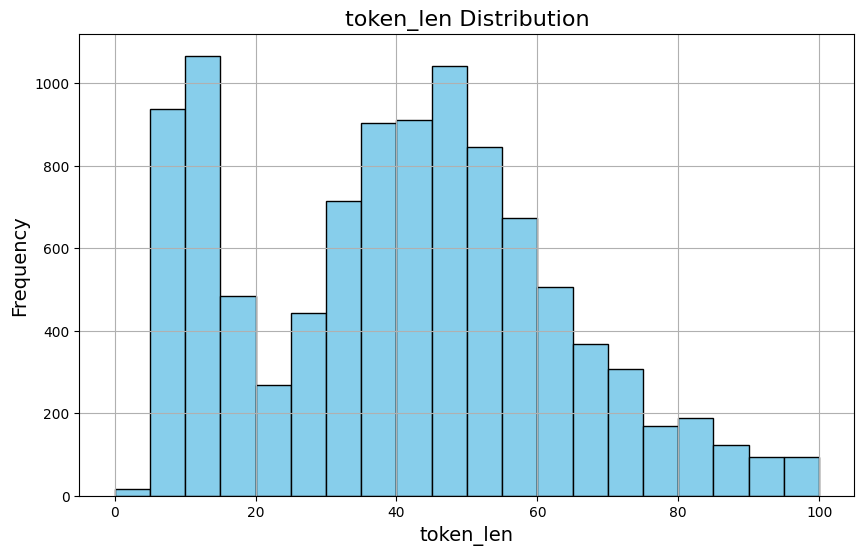


[统计结果] 文件: ./data/forget/forget_v2.jsonl
总条数: 10493
平均 question 长度: 42.93
平均 answer 长度: 113.14
平均 total 长度: 187.06
超过 400 question tokens 的条目数: 1
超过 400 tokens 的条目数: 220


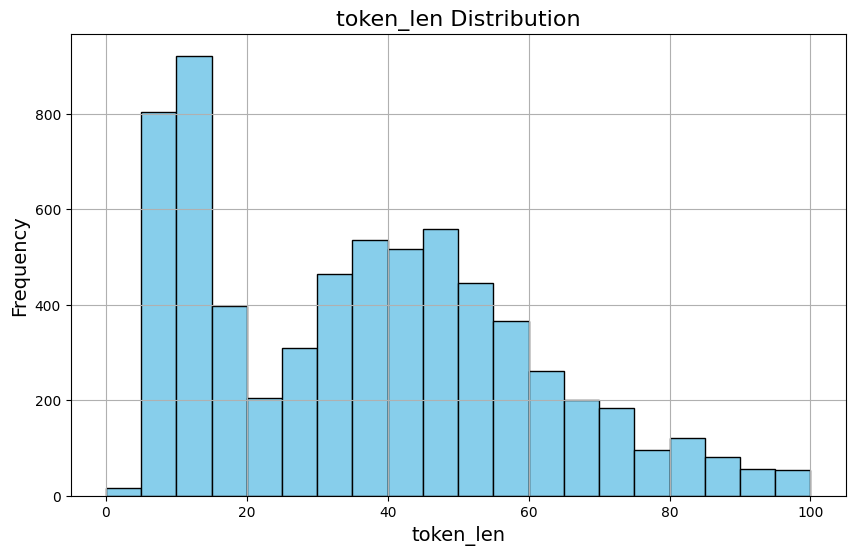


[统计结果] 文件: ./data/forget/forget.jsonl
总条数: 6835
平均 question 长度: 39.70
平均 answer 长度: 109.63
平均 total 长度: 180.33
超过 400 question tokens 的条目数: 0
超过 400 tokens 的条目数: 133


[{'index': 0, 'question_len': 42, 'answer_len': 27, 'total_len': 100},
 {'index': 1, 'question_len': 73, 'answer_len': 103, 'total_len': 207},
 {'index': 2, 'question_len': 48, 'answer_len': 38, 'total_len': 117},
 {'index': 3, 'question_len': 29, 'answer_len': 112, 'total_len': 172},
 {'index': 4, 'question_len': 43, 'answer_len': 62, 'total_len': 136},
 {'index': 5, 'question_len': 52, 'answer_len': 62, 'total_len': 145},
 {'index': 6, 'question_len': 36, 'answer_len': 81, 'total_len': 148},
 {'index': 7, 'question_len': 47, 'answer_len': 55, 'total_len': 133},
 {'index': 8, 'question_len': 48, 'answer_len': 75, 'total_len': 154},
 {'index': 9, 'question_len': 28, 'answer_len': 56, 'total_len': 115},
 {'index': 10, 'question_len': 53, 'answer_len': 79, 'total_len': 163},
 {'index': 11, 'question_len': 34, 'answer_len': 46, 'total_len': 111},
 {'index': 12, 'question_len': 116, 'answer_len': 97, 'total_len': 244},
 {'index': 13, 'question_len': 39, 'answer_len': 42, 'total_len': 112},

In [24]:
# analyze_token_lengths(tokenizer, train_data_path, length_threshold=400)
# analyze_token_lengths(tokenizer, valid_data_path, length_threshold=400)
# analyze_token_lengths(tokenizer, valid_data_path, length_threshold=400)
analyze_token_lengths(tokenizer, "./data/forget/forget_v2.jsonl", length_threshold=400)
analyze_token_lengths(tokenizer, "./data/forget/forget.jsonl", length_threshold=400)

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

# 对比unlearning前后的余弦相似度， 在隐私集上过小说明为学习好。。

# 加载优化过的中文BERT模型
model_name = "/home/lei/lei_data/yinyucup/models/text2vec-base-chinese"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval().cuda()  # 使用 GPU

# 平均池化，忽略 padding 部分
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # [batch, seq_len, hidden]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = input_mask_expanded.sum(dim=1)
    return sum_embeddings / sum_mask

# 获取句子向量
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = mean_pooling(outputs, inputs['attention_mask'])  # [1, hidden_size]
    return embedding

In [ ]:
# 加载参考答案数据
dataset = []
original_line = []
with open(train_data_path, 'r', encoding='utf-8') as f:
    print("loading dataset...")
    for line in f:
        data = json.loads(line)
        dataset.append(data)
        original_line.append(line)

# 加载模型生成结果
data_qwen_gen = []
with open(user_out_path, 'r', encoding='utf-8') as f:
    print("loading user model output...")
    for line in f:
        data = json.loads(line)
        data_qwen_gen.append(data['text'])  # 模型生成的答案


forget_v3_path = "./data/forget/forget-v3.jsonl"
retain_v3_path = "./data/retain/retain-v3.jsonl"

f_forgetv3 = open(forget_v3_path, 'w', encoding='utf-8')
f_retainv3 = open(retain_v3_path, 'w', encoding='utf-8')

# 计算语义相似度
similarity_scores = []
rouge_l_scores = []
forget_v3 = []
retain_v3 = []
for i in tqdm(range(len(dataset))):
    ref_answer = dataset[i]['conversations'][1]['value']
    gen_answer = data_qwen_gen[i]

    embd_ref = get_sentence_embedding(ref_answer)
    embd_gen = get_sentence_embedding(gen_answer)

    sim = F.cosine_similarity(embd_ref, embd_gen).item()
    rouge_l_score = calculate_rouge_l(ref_answer, gen_answer)['f']
    # qa + noun
    # if i < 30000 or i >= 40000:
    #     if sim > 0.8 and rouge_l_score >= 0.5:
    #         forget_v3.append(original_line[i])
    #         f_forgetv3.write(original_line[i])
    #     else:
    #         retain_v3.append(original_line[i])
    #         f_retainv3.write(original_line[i])
    similarity_scores.append(sim)
    rouge_l_scores.append(rouge_l_score)

# similarity_scores_path = "./similarity_scores.txt"
# # 保存相似度结果
# with open(similarity_scores_path, 'w', encoding='utf-8') as f:
#     for score in similarity_scores:
#         f.write(str(score) + '\n')

cos_sim = np.array(similarity_scores)
# print(f"cos less than 0.7: {np.sum(cos_sim < 0.7)}")
# print(f"len of forget:{len(forget_v3)}")
# print(f"len of retain:{len(retain_v3)}")

loading dataset...
loading user model output...


  0%|          | 0/44000 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.857 seconds.
Prefix dict has been built successfully.
100%|██████████| 44000/44000 [16:03<00:00, 45.67it/s]  

cos less than 0.7: 1915
len of forget:6818
len of retain:27182


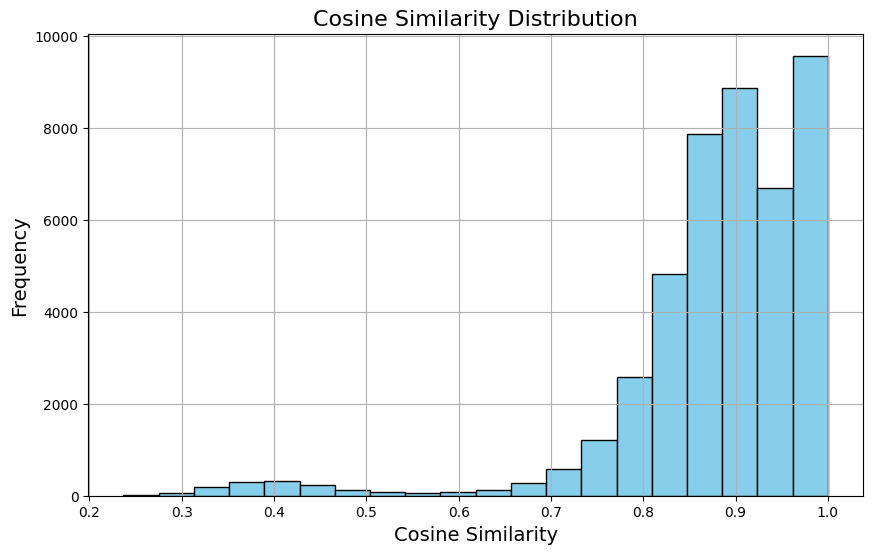

: 

In [ ]:
import matplotlib.pyplot as plt

# 绘制余弦相似度得分的分布图
plt.figure(figsize=(10, 6))
plt.hist(cos_sim, bins=20, color='skyblue', edgecolor='black')
plt.title('Cosine Similarity Distribution', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rouge_l_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Rouge-L Score Distribution', fontsize=16)
plt.xlabel('Rouge-L Scores', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

In [3]:
# valid.json 数据集拆解：privacy
# 根据 privacy 的语义相似度筛选？
# valid验证集下的 privacy标签输出中，根据result结果中的输出内容界定是否为遗忘结果。
# valid数据： qa: 0-799, privacy: 800-1499, choice: 1500-2199, noun: 2200-2499
# 但筛选出的结果是验证集的条目， 基本的思路是利用筛选条目与训练集(已有的forget 与 retain)进行相似性对比，进而筛选

# result_data_path = "./results/ME+GD_epoch3_3e-05_maskFalse_0.7_v4.jsonl"
result_data_path = "./results/origin.jsonl"
# result_data_path = "./results/ME+GD_epoch3_3e-05_maskFalse_0.9_1.0_0807.jsonl"
# result_data_path = "./results/ME+GD_epoch3_3e-05_maskFalse_0.9_1.0_v3.jsonl"

valid_ans = []
original_line = []
with open(valid_data_path,'r',encoding='utf-8') as f:
    print("loading dataset...")
    for line in f:
        data = json.loads(line)
        valid_ans.append(data['conversations'][1]['value'])
        original_line.append(line)


result_data = []
with open(result_data_path,'r',encoding='utf-8') as f:
    print("loading user model output...")
    for line in f:
        data = json.loads(line)
        result_data.append(data['text'])

num_f_qa = 0
num_f_noun = 0
num_f_privacy = 0

data_nonforget_privacy = []
# f_nonforget_priv = open("./data/process/non_forget_priv.jsonl", 'w', encoding='utf-8')

data_forgeted_nonpriv = []
# f_forgeted_nonpriv = open("./data/process/forgeted_nonpriv.jsonl", 'w', encoding='utf-8')
score_priv = score_qa = score_noun = 0.0

for i in tqdm(range(len(valid_ans))):
    # qa
    if i < 800:
        candidate_qa = valid_ans[i]
        reference_qa = result_data[i]
        # 遗忘数据
        if len(reference_qa) <= 10 or reference_qa == "":
            num_f_qa += 1
            data_forgeted_nonpriv.append(original_line[i])
            # f_forgeted_nonpriv.write(original_line[i])
        else:
            try:
                rouge_l_score_qa = calculate_rouge_l(candidate_qa, reference_qa)['f']
                score_qa += rouge_l_score_qa
            except:
                continue
            if rouge_l_score_qa < 0.1:
                num_f_qa += 1
                data_forgeted_nonpriv.append(original_line[i])
                # f_forgeted_nonpriv.write(original_line[i])
    # privacy
    if i >= 800 and i < 1500:
        candidate_privacy = valid_ans[i]
        reference_privacy = result_data[i]
        # 遗忘数据
        if len(reference_privacy) <= 10 or reference_privacy == "":
            num_f_privacy += 1
        else:
            try:
                rouge_l_score_privacy = calculate_rouge_l(candidate_privacy, reference_privacy)['f']
                score_priv += rouge_l_score_privacy
            except:
                continue
            if rouge_l_score_privacy < 0.2:
                num_f_privacy += 1
            elif rouge_l_score_privacy >= 0.3:
                data_nonforget_privacy.append(original_line[i])
                # f_nonforget_priv.write(original_line[i])
    # qa
    if i >= 2200:
        candidate_noun = valid_ans[i]
        reference_noun = result_data[i]
        # 遗忘数据
        if len(reference_noun) <= 10 or reference_noun == "":
            num_f_noun += 1
            data_forgeted_nonpriv.append(original_line[i])
            # f_forgeted_nonpriv.write(original_line[i])
        else:
            try:
                rouge_l_score_noun = calculate_rouge_l(candidate_qa, reference_qa)['f']
                score_noun += rouge_l_score_noun
            except:
                continue
            if rouge_l_score_noun < 0.1:
                num_f_noun += 1
                data_forgeted_nonpriv.append(original_line[i])
                # f_forgeted_nonpriv.write(original_line[i])


f_rate_privacy = num_f_privacy / 700
f_rate_qa = num_f_qa / 800
f_rate_noun = num_f_noun / 300

print(f"rouge_l in label privacy:{score_priv / 700:.6f}")
print(f"rouge_l in label qa:{score_qa / 800:.6f}")
print(f"rouge_l in label noun:{score_noun / 300:.6f}")

print(f"forget rate in label qa:{f_rate_qa:.6f}")
print(f"forget rate in label noun:{f_rate_noun:.6f}")
print(f"non retain rate in other labels:{(num_f_qa + num_f_noun)/1100:.6f}")
print(f"forget rate in label privacy:{f_rate_privacy:.6f}")

loading dataset...
loading user model output...


  0%|          | 0/2500 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.731 seconds.
Prefix dict has been built successfully.
100%|██████████| 2500/2500 [00:13<00:00, 187.66it/s] 

rouge_l in label privacy:0.914462
rouge_l in label qa:0.279904
rouge_l in label noun:0.192308
forget rate in label qa:0.008750
forget rate in label noun:0.000000
non retain rate in other labels:0.006364
forget rate in label privacy:0.000000


In [ ]:
# v-1
# forget rate in label qa:0.373750
# forget rate in label noun:0.390000
# non retain rate in other labels:0.378182
# forget rate in label privacy:0.635714

# v-3
# forget rate in label qa:0.276250
# forget rate in label noun:0.083333
# non retain rate in other labels:0.223636
# forget rate in label privacy:0.320000

# v-2 0.9
# forget rate in label qa:0.725000
# forget rate in label noun:1.000000
# non retain rate in other labels:0.800000
# forget rate in label privacy:0.911429

# v-2 0.7
# forget rate in label qa:0.645000
# forget rate in label noun:1.000000
# non retain rate in other labels:0.741818
# forget rate in label privacy:0.850000

# v-2 0.5 checkpointepoch-2
# forget rate in label qa:0.476250
# forget rate in label noun:0.036667
# non retain rate in other labels:0.356364
# forget rate in label privacy:0.404286

# v-2 0.5
# forget rate in label qa:0.635000
# forget rate in label noun:1.000000
# non retain rate in other labels:0.734545
# forget rate in label privacy:0.824286